In [1]:
# compare the data/mc veto efficiencies for jet veto and rechit vetos

import ROOT as rt
import math
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
from helper_functions import deltaPhi
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [10]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
compareData = 1

if compareData: years = ['16', '17', '18']
else: years = [ '17',]
category = 1
ver = 'V1p17'
# sig_ver = 'v148'
# bkg_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'
# sig_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v147/normalized/'

sig_ver = 'v158'
bkg_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'
sig_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v157/normalized/'



# print("lumi is "+str(round(lumi/1000,2))+" fb-1")

if sig_ver == 'v52':fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
else:fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
for y in years:
    data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data20'+y+'/v5/'+sig_ver+'/normalized/'
    if y == '16':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    elif y == '17':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    else:fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"
    

fpath_bkg['signal'] = sig_path+"ggH_HToSSTodddd_MH-125.root"



for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print(a.shape)

dy_120_800 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v158/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
(140315,)
data16 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v158/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root
(286219,)
data17 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v158/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
(344706,)
data18 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v158/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root
(487341,)
signal /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v157/normalized/ggH_HToSSTodddd_MH-125.root
(22698,)


### Cluster efficiency

In [11]:
%%time
lumi = 137000



jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
nJets = {}
sel_lep = {}
sel_ev = {}
mc_corr_weight = {}
lepOverallSF = {}
nJets2 = {}
jetPt = {}
jetPhi = {}
jetEta = {}
muonPt = {}
muonEta = {}
muonPhi = {}
npu = {}
npv = {}
clusterJetVetoPt = {}
clusterEta = {}
clusterPhi = {}
cluster_match_gLLP_index = {}
cluster_match_gLLP_other_decay_r = {}
cluster_match_gLLP_other_decay_z = {}
cluster_match_gLLP_decay_r = {}
cluster_match_gLLP_decay_z = {}
clusterMuonVetoPt = {}
clusterMuonVetoGlobal = {}
clusterMuonVetoLooseId = {}
clusterSize= {}
muonPt_cut = 50
norm = 50
tag_probe = True
masses = [('120','800')]
cluster_index = ''
csc = 1
for k, T in tree_bkg.items():
########## select cluster ########
    if csc:
        sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') >= 0
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5,\
                                                                             T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1.0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')< 0.4)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))>550)

    else:
        sel_rechitcluster = np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>=0.9))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster' + cluster_index + '_match_gLLP'))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')< 0.4)

#         sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))>550)

    print(k,np.count_nonzero(sel_rechitcluster.sum()))
############ BRANCHES ############
    if k == 'signal':
        sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
        sel_ev[k] = T.array('METTrigger')
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
#         sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == category)
#         sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
        sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
        sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)
        if csc:
            clusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterMuonVetoGlobal[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoGlobal')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterSize[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            cluster_match_gLLP_index[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            cluster_match_gLLP_other_decay_r[k] = ((T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2)**0.5)[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])),1-cluster_match_gLLP_index[k]]
            cluster_match_gLLP_other_decay_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])), 1-cluster_match_gLLP_index[k]]
            cluster_match_gLLP_decay_r[k] = ((T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2)**0.5)[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])),cluster_match_gLLP_index[k]]
            cluster_match_gLLP_decay_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])),cluster_match_gLLP_index[k]]

        else:
            clusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterMuonVetoLooseId[k] = T.array('dtRechitClusterMuonVetoLooseId')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


            clusterEta[k] = T.array('dtRechitClusterEta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterSize[k] = T.array('dtRechitClusterSize')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            clusterPhi[k] = T.array('dtRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            cluster_match_gLLP_index[k] = T.array('dtRechitCluster_match_gLLP_index')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
            cluster_match_gLLP_decay_r[k] = ((T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2)**0.5)[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])),cluster_match_gLLP_index[k]]
            cluster_match_gLLP_other_decay_r[k] = ((T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2)**0.5)[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])),1-cluster_match_gLLP_index[k]]
            cluster_match_gLLP_other_decay_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][np.arange(np.count_nonzero(sel_ev[k])), 1-cluster_match_gLLP_index[k]]
            
        weight[k] = (T.array('weight') * T.array('pileupWeight') * T.array('higgsPtWeight'))[sel_ev[k]]
    else:
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt_cut).sum()==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<800)
        weight[k] = T.array('weight')[sel_ev[k]]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]]
        if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]]
    #         if k[:2] == 'dy': lepOverallSF[k] = pileupWeight[k]*0.0+1.0
        ZMass[k]= T.array('ZMass')[sel_ev[k]]
        ZMass[k]= T.array('ZMass')[sel_ev[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]]
        nJets[k] = T.array('nJets')[sel_ev[k]]
        sel_jet = np.abs(T.array('jetEta')) <=2.4
        if csc: sel_jet = np.logical_and(sel_jet, T.array('jetPt')>30)
        else: 
            sel_jet = np.logical_and(sel_jet, T.array('jetPt')>50)
#             sel_jet = np.logical_and(sel_jet, T.array('jetTightPassId'))
        nJets2[k] = (sel_jet.sum())[sel_ev[k]]
        jetPt[k] = T.array('jetPt')[sel_jet][sel_ev[k]]
        jetEta[k] = T.array('jetEta')[sel_jet][sel_ev[k]]
        jetPhi[k] = T.array('jetPhi')[sel_jet][sel_ev[k]]


        if csc:
            sel_muon = T.array('GlobalMuonPt')>=30
            muonPt[k] = T.array('GlobalMuonPt')[sel_muon][sel_ev[k]]
            muonEta[k] = T.array('GlobalMuonEta')[sel_muon][sel_ev[k]]
            muonPhi[k] = T.array('GlobalMuonPhi')[sel_muon][sel_ev[k]]

        else:
            sel_muon = np.logical_and(T.array('GlobalMuonPt')>=10, T.array('GlobalMuonLooseId'))
            muonPt[k] = T.array('GlobalMuonPt')[sel_muon][sel_ev[k]]
            muonEta[k] = T.array('GlobalMuonEta')[sel_muon][sel_ev[k]]
            muonPhi[k] = T.array('GlobalMuonPhi')[sel_muon][sel_ev[k]]

        mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]]
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
        if 'dy' in k:  weight[k] = (T.array('weight') * T.array('pileupWeight'))[sel_ev[k]] * mc_corr_weight[k] * lumi
        else: weight[k] = np.ones(ZMass[k].shape)
            
    npu[k] = T.array('npu')[sel_ev[k]]
    npv[k] = T.array('npv')[sel_ev[k]]
    print(k,np.sum(weight[k]),np.count_nonzero(sel_ev[k]))

dy_120_800 0
dy_120_800 1126957.2726667582 138739
data16 0
data16 281279.0 281279
data17 0
data17 342046.0 342046
data18 0
data18 483812.0 483812
signal 1111
signal 12416.566 947
CPU times: user 16.1 s, sys: 1.82 s, total: 17.9 s
Wall time: 23.4 s


In [12]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while np.count_nonzero(dphi.flatten() > math.pi):
        dphi = dphi - (dphi > math.pi)*2*math.pi
    while np.count_nonzero(dphi.flatten() <= -math.pi):
        dphi = dphi + (dphi <= -math.pi)*2*math.pi
    return dphi



# make jet cone

In [13]:
#phi is just random number betwen 0 and 359
# eta, took the distribution directly, no weights taken into account
CLUSTER_PER_EVT = 5
veto = 1


if veto == 0:
    var_eta = jetEta
    var_phi = jetPhi
else:
    var_eta = muonEta
    var_phi = muonPhi

###########
# 0: jetveto; 1:muon veto
###########

matched = {}
if compareData: ll = ['data16','data17','data18', 'dy_120_800']
else: ll = ['data17', 'dy_120_800']
for k in ll:
    print(k)
    # randomly pick the bin, and then randomly choose where in the bin it is
    if csc:hist, bins = np.histogram(np.abs(clusterEta['signal']),bins = 50,range=[0.8,2.5],weights = weight['signal'])
    else:hist, bins = np.histogram(np.abs(clusterEta['signal']),bins = 30,range=[0, 1.2],weights = weight['signal'])
    bin_width = bins[1]-bins[0]
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[k]))
    pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[k]))-0.5)*bin_width
    signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[k]))
    signs[signs < 0.5] = -1
    signs[signs >= 0.5] = 1

    value_bins = np.searchsorted(cdf, values)
    
    eta = bin_midpoints[value_bins]*signs+pos_in_bin
    # for phi, randomly pick a point between 0,360
    phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[k]))/180.0*math.pi

    # calculate deltaR between cluster the the jet/hits
    deltaR = ((eta-var_eta[k][np.repeat(np.arange(len(var_eta[k])), CLUSTER_PER_EVT)])**2 + \
              deltaPhi(phi,var_phi[k][np.repeat(np.arange(len(var_eta[k])), CLUSTER_PER_EVT)])**2)**0.5

    #  awkward.fromiter(dphi)**2)**0.5
    print(len(deltaR))
    matched[k] = (deltaR<0.4).any()
    print(k, 1-np.count_nonzero(matched[k])/ len(deltaR))


data16
1406395
data16 0.9687043824814507
data17
1710230
data17 0.9689784414961731
data18
2419060
data18 0.9691433862740073
dy_120_800
693695
dy_120_800 0.9689532143088821


# jet veto efficiency

data16 0.9687043824814509 0.00014684114458030084 0.00014750929161555515
data17 0.9689784414961731 0.00013259267438092692 0.00013314232291516959
data18 0.9691433862740073 0.00011119713371088302 0.00011158572739800032
0.9988005185763236 0.0033801415205160974 0.9996562695998557 0.0005946579518756385
1.0022649777446462 0.0036954968731107703 1.000702602429129 0.0006781383037250389


Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TCanvas::Constru

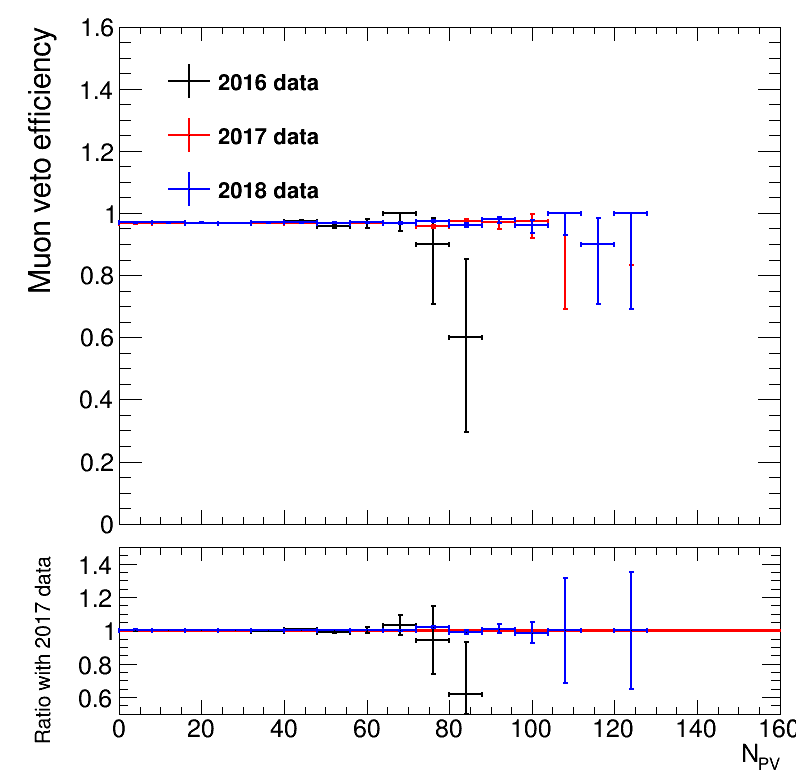

In [14]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
hb = {}
pEff = {}
var = [ZMass, ZPt, nJets, nJets2,npv, cluster_match_gLLP_decay_r, cluster_match_gLLP_decay_z]
title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','N_{PV}','decay r [cm]', 'decay z [cm]']
bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15],  [20,0,160], [50,0,1000], [50,0,1000]]
names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv', 'decayR', 'decayZ']
ratio = [[0.5,1.5], [0.5,1.5], [0.5,1.5],[0.5,1.5],[0.5,1.5], [0.5,1.5], [0.5,1.5]]
assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )


veto_yaxis = ['Jet veto efficiency', 'Muon veto efficiency']
reweight  = 0
reweight_index = 4

if veto == 0:dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/jet_veto_eff/'
else: dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/muon_veto_eff/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)
    
if compareData:key_list = ['data16','data17','data18',]
else:key_list = ['data17','dy_120_800', 'signal']
for j in range(len(bins)):
    if not j == 4: continue
    for i, k in enumerate(key_list):
#     for i, k in enumerate(['data17','dy_120_800', 'signal']):
        if j >=5  and not 'signal' in k:continue
        if k == 'signal' and j < 4:continue
        total_weight = weight[k]
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if k == 'data': total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if reweight and not 'signal' in k:
#             print(np.sum(weight[k]))
            h_reweight = {}
#             print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data17']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            total_weight = total_weight * np.array(reweight)


        if k == 'signal':
            if csc:outside = np.logical_or(cluster_match_gLLP_other_decay_r[k]>700, np.abs(cluster_match_gLLP_other_decay_z[k])>1100)
            else: outside = np.logical_or(cluster_match_gLLP_other_decay_r[k]>750, np.abs(cluster_match_gLLP_other_decay_z[k])>700)
                
            if veto == 0:
                if csc: nominator = np.logical_and(outside, clusterJetVetoPt[k]<30)
                else: nominator = np.logical_and(outside, clusterJetVetoPt[k]<50)
            else: 
                if csc: nominator = np.logical_and(outside, np.logical_not(np.logical_and(clusterMuonVetoPt[k]>=100, clusterMuonVetoGlobal[k])))
                else: nominator = np.logical_and(outside, np.logical_not(np.logical_and(clusterMuonVetoPt[k]>=10, clusterMuonVetoLooseId[k])))
                    
            hm[k] = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[nominator]) 
            hb[k] = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[outside])
            
            m = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[nominator]) 
            b = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[outside])
            pEff_inclusive = rt.TEfficiency(m,b)
            print(k, pEff_inclusive.GetEfficiency(1), pEff_inclusive.GetEfficiencyErrorUp(1), pEff_inclusive.GetEfficiencyErrorLow(1))
            
        else:
            hm[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
            hb[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
            m = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
            b = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                    binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
            pEff_inclusive = rt.TEfficiency(m,b)
            print(k, pEff_inclusive.GetEfficiency(1), pEff_inclusive.GetEfficiencyErrorUp(1), pEff_inclusive.GetEfficiencyErrorLow(1))

        pEff[k] = rt.TEfficiency(hm[k],hb[k])
        pEff[k].SetLineColor(std_color_list[i])
        pEff[k].SetLineWidth(2)
        
        # inclusive efficiency calculation
        
        
    if compareData:
        if j == 4: c = make_ratio_pEff([pEff['data16'], pEff['data17'], pEff['data18']], fit = False, logy=False, \
                        in_tags = ["2016 data", '2017 data', '2018 data'], ratio_index = 1, ratio_bounds = ratio[j], draw_opt = ['E1','E2','E1']) 
        elif j >= 5:
            pEff['signal'].SetLineWidth(3)
            pEff['signal'].Draw()
    #         c = make_ratio_pEff([pEff['signal'],pEff['signal']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 


        else: c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    else:
#         if j == 4: c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17'],pEff['signal']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region","MC Signal"],\
#                             ratio_bounds = ratio[j], draw_opt = ['E2','E1','E1'])
#         elif j >= 5:
#             pEff['signal'].SetLineWidth(3)
#             pEff['signal'].Draw()
#     #         c = make_ratio_pEff([pEff['signal'],pEff['signal']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 


#         else: c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
        c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 

    
    #     else: 
#     c = make_ratio_pEff([pEff['dy_120_800'],pEff['data16'], pEff['data17'], pEff['data18']], fit = False, logy=False, \
#                         in_tags = ["MC","2016 data", '2017 data', '2018 data'], ratio_bounds = ratio[j], draw_opt = ['E2','E1', 'E1', 'E1']) 
#     print(pEff.keys())
#     c = make_ratio_pEff([pEff['data16'], pEff['data17'], pEff['data18']], fit = False, logy=False, \
#                         in_tags = ["2016 data", '2017 data', '2018 data'], ratio_index = 1, ratio_bounds = ratio[j], draw_opt = ['E1','E2','E1']) 
#     c.Draw()
#     c.SaveAs(dir_name+veto_names[veto]+'_eff_compareY_'+names[j]+'.png')
#     c.SaveAs(dir_name+veto_names[veto]+'_eff_compareY_'+names[j]+'.C')

    c.Draw()
    
    
    if csc: name = dir_name+'cscveto_eff_'+names[j]
    else:name = dir_name+'dtveto_eff_'+names[j]
    if reweight: name +='_reweight'+names[reweight_index]
    if compareData: name+= "_compareDataYear"
    c.SaveAs(name+'.png')
    c.SaveAs(name+'.C')

# distributions

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
var = [ZMass, ZPt, nJets, nJets2,npv]
title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','npv']
bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15], [20,0,160]]
names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv']
ratio = [[0.5,1.5], [0.0,2], [0.5,1.5],[0.5,3],[0.5,5]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/jet_veto_eff/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)


reweight  = 0
reweight_index = 1
for j in range(len(bins)):
    if not j == 1: continue
    for i, k in enumerate(['data','dy_120_800']):

        total_weight = weight[k]
        print(weight[k][0])
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if 'data' in k: total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if ('dy' in k) and reweight:
            print(np.sum(total_weight))
            h_reweight = {}
            print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            print(weight[k][0])

            total_weight = total_weight * reweight

            
        
        h[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        
        print(k,h[k].Integral(),len(total_weight))
    c = make_ratio_plot([h['dy_120_800'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    c.Draw()
      
#     if not reweight:
#         c.SaveAs(dir_name+names[j]+'.png')
#         c.SaveAs(dir_name+names[j]+'.C')
#     else:
#         c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')
#         c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')




[10] [5]
